In [1]:
## Referencias
### https://github.com/sebp/scikit-survival
### https://nbviewer.jupyter.org/github/sebp/scikit-survival/blob/master/examples/00-introduction.ipynb
### https://medium.com/@sundarstyles89/weight-of-evidence-and-information-value-using-python-6f05072e83eb

In [2]:
import platform
print(platform.python_version())

3.6.8


In [3]:
import pandas as pd
import datetime as dt
import unicodedata
import numpy as np
# import sksurv as ss
# from sksurv.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
# from sksurv.linear_model import CoxPHSurvivalAnalysis
# from sksurv.metrics import concordance_index_censored
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import math

#### Getting and preparing dataframe

In [4]:
# df = pd.read_csv('first_sale_times_20171201_customer_data.csv')

In [5]:
df_first_order = pd.read_csv('customer_and_first_order_data_v3.csv', encoding='utf-8', sep=';')

In [9]:
pd.concat([df_first_order.head(3), df_first_order.tail(3)])

,fk_customer,channel,partner,device,first_sale_number,age,gender,state,expected_delivery_date,delivered_date,first_sale_date,second_sale_date
0,1672,EXCHANGED,EXCHANGED,APP ANDROID,590541,30,female,são paulo,NaN,20180811.0,20180621,20180708.0
1,20205,DIRECT,UNKNOWN,DESKTOP,37325554,61,female,paraná,20180516.0,20180509.0,20180503,NaN
2,32783,CRM - EMAIL,EMAIL_TRANSACIONAL,DESKTOP,75358614,26,female,rio grande do sul,20180705.0,20180618.0,20180511,20180511.0
1352643,31039668,UNKNOWN,UNKNOWN,APP ANDROID,4465666624,33,female,são paulo,NaN,NaN,20190116,NaN
1352644,31040197,UNKNOWN,UNKNOWN,DESKTOP,4465660190,36,male,são paulo,20190129.0,NaN,20190116,NaN
1352645,31042838,UNKNOWN,UNKNOWN,DESKTOP,4465667630,26,male,rio grande do norte,NaN,NaN,20190116,NaN


In [10]:
df_categories = pd.read_csv('first_orders_categories_v3.csv', encoding='utf-8', sep=';')

In [11]:
pd.concat([df_categories.head(), df_categories.tail()])

,first_sale_date,first_sale_number,fk_customer,has_marketplace,has_crossdocking,has_private_label,has_brands,gmv
0,2018-01-08 15:47:40,14622844,25850737,0,0,0,1,149.99
1,2018-03-12 11:34:39,26228194,26506040,0,0,0,1,258.89
2,2018-05-03 12:16:38,33337554,27170929,0,0,0,1,297.60
3,2018-02-19 08:14:16,25334564,26328512,0,0,0,1,144.95
4,2018-06-08 08:48:14,31751334,27698529,0,0,0,1,69.99
1395689,2018-09-17 18:47:16,4461295430,29049769,0,0,0,1,79.99
1395690,2019-01-10 10:45:28,4465462728,21263350,0,0,0,1,84.99
1395691,2018-09-27 00:31:32,4461592256,24224728,0,0,0,1,114.89
1395692,2018-11-22 20:02:06,4463630569,30068824,0,0,0,1,84.99
1395693,2018-10-09 20:33:31,4462017531,29286340,0,0,0,1,94.99


In [12]:
print(len(df_first_order))
print(df_categories.first_sale_number.nunique())

1352646
1395694


In [13]:
df_grouped = df_categories.copy()
df_grouped.drop(columns=['first_sale_date'], inplace=True)

In [14]:
len(df_first_order)

1352646

In [15]:
len(df_grouped)

1395694

In [16]:
df = pd.merge(df_first_order, df_grouped, on=['first_sale_number','fk_customer'], how='outer', indicator=True)

In [17]:
df.head()

,fk_customer,channel,partner,device,first_sale_number,age,gender,state,expected_delivery_date,delivered_date,first_sale_date,second_sale_date,has_marketplace,has_crossdocking,has_private_label,has_brands,gmv,_merge
0,1672,EXCHANGED,EXCHANGED,APP ANDROID,590541,30.0,female,são paulo,NaN,20180811.0,20180621.0,20180708.0,1.0,0.0,0.0,0.0,79.90,both
1,20205,DIRECT,UNKNOWN,DESKTOP,37325554,61.0,female,paraná,20180516.0,20180509.0,20180503.0,NaN,0.0,0.0,0.0,1.0,160.00,both
2,32783,CRM - EMAIL,EMAIL_TRANSACIONAL,DESKTOP,75358614,26.0,female,rio grande do sul,20180705.0,20180618.0,20180511.0,20180511.0,0.0,1.0,0.0,0.0,119.90,both
3,32843,CRM - EMAIL,EMAIL_TRANSACIONAL,M+T SITE,4463800326,25.0,female,minas gerais,20181214.0,20181205.0,20181123.0,NaN,0.0,0.0,0.0,1.0,302.95,both
4,40115,CRM - EMAIL,EMAIL_TRANSACIONAL,DESKTOP,55346854,29.0,male,são paulo,20180509.0,20180502.0,20180428.0,NaN,0.0,0.0,0.0,1.0,99.00,both


In [ ]:
df.groupby('_merge').size()

In [ ]:
pd.concat([df.head(), df.tail()])

In [ ]:
df = df[df['_merge'] == 'both'].copy()
df.drop(['_merge'], axis='columns', inplace=True)

In [ ]:
df.info(memory_usage='deep')

In [ ]:
pd.concat([df.head(), df.tail()])

#### Estudo da distribuição da segunda compra por Partner

In [ ]:
df_second_sale = df[df['second_sale_date'].notnull()]

In [ ]:
df_partners = df_second_sale.groupby('partner').size().reset_index(name='counts').sort_values(by=['counts'],ascending=False)

In [ ]:
df_partners['sum'] = df_partners['counts'].cumsum()

In [ ]:
df_partners['perc'] = 100*df_partners['sum']/df_partners['counts'].sum()

In [ ]:
df_partners['partners_new'] = np.where(df_partners['perc']<90, df_partners['partner'], 'OTHER')

In [ ]:
df_partners_map = df_partners[['partner','partners_new']].copy()

In [ ]:
df_test = pd.merge(df, df_partners_map, on='partner', how='outer', indicator=True)

In [ ]:
df_test.head()

In [ ]:
df_test = df_test[df_test['_merge'] == 'both'].copy()
df_test.drop(['_merge'], axis='columns', inplace=True)
df_test.drop(['partner'], axis='columns', inplace=True)

In [ ]:
df_test.head()

In [ ]:
del(df_first_order)
#del(df_categories_share)
del(df_categories)

In [ ]:
def date_str_to_date(date_str):
    try:
        date_str = dt.datetime.strptime(date_str,'%Y%m%d')
    except:
        return None
    return date_str

def date_to_char(date_float):
    return str(date_float).replace('.0','')

def remove_accents(string_text):
    normal = str(unicodedata.normalize('NFKD', string_text).encode('ASCII', 'ignore'))
    normal = normal.replace("b'","")
    normal = normal.replace("'","")
    return normal

def age_grouping(integer_age):
    if integer_age <= 18:
        age_group = "<18"
    elif integer_age <= 35:
        age_group = "18-35"
    elif integer_age <= 55:
        age_group = "35-55"
    else:
        age_group = "55+"
    return age_group

def timedelta_to_int(timedelta):
    return timedelta.days

def gmv_group_woe(gmv_float):
    if gmv_float <= 75:
        gmv_group = '0-75'
    elif gmv_float <= 100:
        gmv_group = '75-100'
    elif gmv_float <= 135:
        gmv_group = '100-135'
    elif gmv_float <= 155:
        gmv_group = '135-155'
    elif gmv_float <= 185:
        gmv_group = '155-185'
    elif gmv_float <= 200:
        gmv_group = '185-200'
    elif gmv_float <= 245:
        gmv_group = '200-245'
    elif gmv_float <= 335:
        gmv_group = '245-335'
    else:
        gmv_group = '335+'
    return gmv_group

def age_group_woe(age_float):
    if age_float <= 22.0:
        age_group = '0-22'
    elif age_float <= 24.0:
        age_group = '22-24'
    elif age_float <= 27.0:
        age_group = '24-27'
    elif age_float <= 32.0:
        age_group = '27-32'
    elif age_float <= 43.0:
        age_group = '32-43'
    elif age_float <= 51.0:
        age_group = '43-51'
    else:
        age_group = '51+'
    return age_group

def state_group_woe(state):
    if (state == 'roraima' or state == 'rio de janeiro' or state == 'rondonia'):
        state_grouped = 'Group 1'
    elif (state == 'ceara' or state == 'santa catarina' or state == 'minas gerais' or state == 'mato grosso do sul' or state == 'tocantins'):
        state_grouped = 'Group 2'
    elif (state == 'paraiba' or state == 'rio grande do norte' or state == 'rio grande do sul'):
        state_grouped = 'Group 3'
    elif (state == 'espirito santo' or state == 'amapa'):
        state_grouped = 'Group 4'
    elif (state == 'sao paulo' or state == 'piaui' or state == 'acre' or state == 'sergipe'):
        state_grouped = 'Group 5'
    elif (state == 'parana' or state == 'pernambuco' or state == 'goias'):
        state_grouped = 'Group 6'
    elif (state == 'bahia' or state == 'distrito federal' or state == 'alagoas' or state == 'amazonas' or state == 'para'):
        state_grouped = 'Group 7'
    else:
        state_grouped = 'Group 8'
    return state_grouped

def chance_when_bought(row):
    return row[2].y[row[1]]


In [ ]:
df_backup = df.copy()

In [ ]:
df = df_test.copy()

In [ ]:
df = df[df['gender'].notnull()]

In [ ]:
len(df)

In [ ]:
df.loc[:, 'first_sale_date'] = df['first_sale_date'].apply(date_to_char)
df['second_sale_date'] = df['second_sale_date'].apply(date_to_char)

In [ ]:
df['first_sale_date'] = df['first_sale_date'].apply(date_str_to_date)
df['second_sale_date'] = df['second_sale_date'].apply(date_str_to_date)

In [ ]:
df['delta'] = (df['second_sale_date'] - df['first_sale_date'])
df['age_grouped'] = df['age'].apply(age_group_woe)
df['state'] = df['state'].apply(remove_accents)

In [ ]:
df['status'] = df['delta'].notnull()
df['second_sale_date']= df['second_sale_date'].fillna(dt.date.today())
df['delta'] = (df['second_sale_date'] - df['first_sale_date'])

In [ ]:
df['state_grouped'] = df['state'].apply(state_group_woe)

In [ ]:
pd.concat([df.head(), df.tail()])

#### Agrupamento de GMV usando WOE

In [ ]:
df['gmv'].describe(percentiles=[.1,.2,.3,.4,.5,.6,.7,.8,.9])

In [ ]:
df['gmv_grouped'] = df['gmv'].apply(gmv_group_woe)

In [ ]:
df_gmv_grouped = df.groupby(['gmv_grouped','status'])

In [ ]:
df_aux = pd.DataFrame(df_gmv_grouped.size()).reset_index()

In [ ]:
df_success = pd.DataFrame(df_aux[df_aux['status']==True].copy())
df_success.rename(columns={0:'success'}, inplace=True)
df_success.drop(['status'], axis='columns', inplace=True)
df_success.reset_index()

df_nonsuccess = pd.DataFrame(df_aux[df_aux['status']==False].copy())
df_nonsuccess.rename(columns={0:'nonsuccess'}, inplace=True)
df_nonsuccess.drop(['status'], axis='columns', inplace=True)
df_nonsuccess.reset_index()


In [ ]:
df_test = pd.merge(df_success, df_nonsuccess, on='gmv_grouped', how='outer')

In [ ]:
df_test['success'] = df_test['success'].astype(float)
df_test['nonsuccess'] = df_test['nonsuccess'].astype(float)

In [ ]:
df_test['succ/nonsucc'] = df_test['success']/df_test['nonsuccess']
df_test['woe'] = df_test['succ/nonsucc'].apply(math.log)
df_test['iv'] = ((df_test['success']/(df_test['success']+df_test['nonsuccess']))-(df_test['nonsuccess']/(df_test['success']+df_test['nonsuccess'])))*df_test['woe']

In [ ]:
df_test

#### Agrupamento de idade usando WOE

In [ ]:
df['age'].describe(percentiles=[.1,.2,.3,.4,.5,.6,.7,.8,.9])

In [ ]:
df['age_grouped'] = df['age'].apply(age_group_woe)

In [ ]:
df_age_grouped = df.groupby(['age_grouped','status'])

In [ ]:
df_aux = pd.DataFrame(df_age_grouped.size()).reset_index()

In [ ]:
df_success = pd.DataFrame(df_aux[df_aux['status']==True].copy())
df_success.rename(columns={0:'success'}, inplace=True)
df_success.drop(['status'], axis='columns', inplace=True)
df_success.reset_index()

df_nonsuccess = pd.DataFrame(df_aux[df_aux['status']==False].copy())
df_nonsuccess.rename(columns={0:'nonsuccess'}, inplace=True)
df_nonsuccess.drop(['status'], axis='columns', inplace=True)
df_nonsuccess.reset_index()


In [ ]:
df_test = pd.merge(df_success, df_nonsuccess, on='age_grouped', how='outer')

In [ ]:
df_test['success'] = df_test['success'].astype(float)
df_test['nonsuccess'] = df_test['nonsuccess'].astype(float)

In [ ]:
df_test['succ/nonsucc'] = df_test['success']/df_test['nonsuccess']
df_test['woe'] = df_test['succ/nonsucc'].apply(math.log)
df_test['iv'] = ((df_test['success']/(df_test['success']+df_test['nonsuccess']))-(df_test['nonsuccess']/(df_test['success']+df_test['nonsuccess'])))*df_test['woe']

In [ ]:
df_test

#### Agrupamento de estados usando WOE

In [ ]:
df_state_grouped = df.groupby(['state','status'])

In [ ]:
df_aux = pd.DataFrame(df_state_grouped.size()).reset_index()

In [ ]:
df_success = pd.DataFrame(df_aux[df_aux['status']==True].copy())
df_success.rename(columns={0:'success'}, inplace=True)
df_success.drop(['status'], axis='columns', inplace=True)
df_success.reset_index()

df_nonsuccess = pd.DataFrame(df_aux[df_aux['status']==False].copy())
df_nonsuccess.rename(columns={0:'nonsuccess'}, inplace=True)
df_nonsuccess.drop(['status'], axis='columns', inplace=True)
df_nonsuccess.reset_index()


In [ ]:
df_test = pd.merge(df_success, df_nonsuccess, on='state', how='outer')

In [ ]:
df_test['success'] = df_test['success'].astype(float)
df_test['nonsuccess'] = df_test['nonsuccess'].astype(float)

In [ ]:
df_test['succ/nonsucc'] = df_test['success']/df_test['nonsuccess']
df_test['woe'] = df_test['succ/nonsucc'].apply(math.log)
df_test['iv'] = ((df_test['success']/(df_test['success']+df_test['nonsuccess']))-(df_test['nonsuccess']/(df_test['success']+df_test['nonsuccess'])))*df_test['woe']

In [ ]:
df_test.sort_values(by=['iv'], ascending=False)

#### Aplicação do algoritmo

In [ ]:
df.columns

In [ ]:
desired_columns = ['fk_customer', 'channel', 'partners_new', 'device',
                   'age_grouped', 'gender', 'has_marketplace',
       'has_crossdocking', 'has_private_label', 'has_brands', 'state_grouped', 'gmv_grouped']

In [ ]:
categorical_columns = ['channel', 'partners_new', 'device', 'age_grouped', 'gender', 'state_grouped', 'gmv_grouped']

In [ ]:
y_columns = ['status', 'delta']

In [ ]:
used_columns = desired_columns + y_columns

In [ ]:
data_x = df[desired_columns].copy()
data_x = data_x.set_index('fk_customer')
for i in categorical_columns:
    data_x[i] = data_x[i].astype('category')
data_x_numeric = OneHotEncoder().fit_transform(data_x)

In [ ]:
data_y_df = df[y_columns].copy()
data_y_df['delta'] = data_y_df['delta'].apply(timedelta_to_int)
data_y_df['delta'] = data_y_df['delta']/7
data_y_df['delta'] = data_y_df['delta'].apply(math.ceil)

In [ ]:
data_y = data_y_df.to_records(index=False)

In [ ]:
data_x_numeric.isnull().values.any()

In [ ]:
data_x_numeric = data_x_numeric.reset_index()
data_x_numeric.set_index('fk_customer', inplace=True)

In [ ]:
data_x_numeric.head()

In [ ]:
pd.concat([data_y_df.head(), data_y_df.tail()])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data_x_numeric, data_y, test_size=0.33, random_state=42)

In [ ]:
x_train, x_train_small, y_train, y_train_small = train_test_split(x_train, y_train, test_size=0.09, random_state=105)

In [ ]:
estimator = CoxPHSurvivalAnalysis()
estimator.fit(x_train, y_train)

In [ ]:
pd.Series(estimator.coef_, index=x_train.columns).sort_values(ascending=True)

In [ ]:
#prediction = estimator.predict(x_test)
#result = concordance_index_censored(y_test['status'], y_test['delta'], prediction)
#result[0]
estimator.score(x_train_small, y_train_small)

In [ ]:
x_sample = x_test.sample(n=5)
pred_surv = estimator.predict_survival_function(x_sample)
for i, c in enumerate(pred_surv):
    plt.step(c.x, c.y, where="post", label="Sample %d" % (i + 1))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

In [ ]:
pred_surv_full = estimator.predict_survival_function(x_test)

In [ ]:
y_test = pd.DataFrame(y_test)

In [ ]:
y_test['function'] = pred_surv_full

In [ ]:
y_validation = y_test[y_test['status'] == True]

In [ ]:
#y_validation['function'][3].y[y_validation['delta'][3]]
#y_validation['function'][3].y[y_validation['delta'][3]]
#y_validation['%_sale'] = y_validation['function'].y[y_validation['delta']]

y_validation['%_survive'] = y_validation.apply(chance_when_bought,axis=1)

In [ ]:
y_validation['%_survive'].describe(percentiles=[.1,.2,.3,.4,.5,.6,.7,.8,.9])

In [ ]:
dict_aux = {'W1':[],'W4':[],'W9':[],'W13':[],'W26':[],'W52':[]}
for i in pred_surv_full:
    dict_aux['W1'].append(i.y[0])
    dict_aux['W4'].append(i.y[3])
    dict_aux['W9'].append(i.y[8])
    dict_aux['W13'].append(i.y[12])
    dict_aux['W26'].append(i.y[25])
    dict_aux['W52'].append(i.y[51])
df_results = pd.DataFrame(dict_aux)


In [ ]:
for i in df_results.columns:
    print(i)
    print(df_results[i].describe(percentiles=[.1,.2,.3,.4,.5,.6,.7,.8,.9]))
    print()

In [ ]:
df_result_w9 = pd.DataFrame(df_results['W9'].copy())
df_result_w9.head()

In [ ]:
y_validation_w9 = y_validation[y_validation['delta'] >= 9]

In [ ]:
y_validation_w9['decile'] = pd.qcut(y_validation_w9['%_survive'], 10, labels=False)

In [ ]:
y_validation_w9.head()

In [ ]:
y_validation_w9['convert_w9'] = np.where(y_validation_w9['delta']<=9, 1, 0)

In [ ]:
y_validation_w9_grouped = y_validation_w9.groupby(['decile'])['convert_w9'].sum()

In [ ]:
y_validation_w9_grouped

In [ ]:
y_validation_w9_prob = y_validation_w9.groupby(['decile'])['%_survive'].mean()

In [ ]:
y_validation_w9_prob

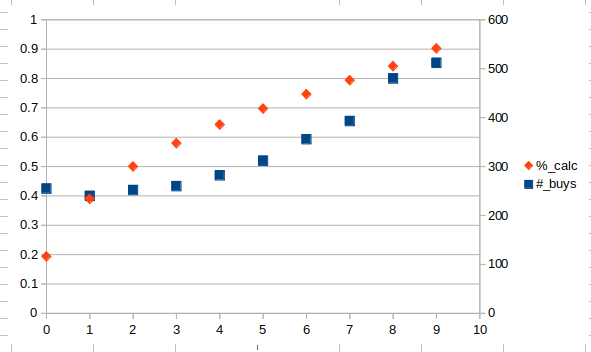

##### Testando relevância de features isoladas

In [ ]:
isinstance(x_train_small, pd.DataFrame)

In [ ]:
def fit_and_score_features(x, y):
    X = x.values
    n_features = X.shape[1]
    scores = np.zeros(n_features)
    m = CoxPHSurvivalAnalysis()
    
    ## Algumas features geram um erro de Singular Matrix (matrizes quadradas sem inversa)
    for j in range(n_features):
        Xj = X[:, j:j+1]
        try:
            m.fit(Xj, y)
            scores[j] = m.score(Xj, y)
        except:
            pass
        print(j, x.columns.tolist()[j], scores[j])
    return scores

In [ ]:
scores = fit_and_score_features(x_train_small, y_train_small)

In [ ]:
pd.Series(scores, index=x_train.columns).sort_values(ascending=False)

##### Testando combinações de features

In [ ]:
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.zeros(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        #print(j)
        Xj = X[:, j:j+1]
        try:
            m.fit(Xj, y)
            scores[j] = m.score(Xj, y)
        except:
            pass
    print(scores)
    return scores

In [ ]:
data_x_modified = data_x.copy()
data_x_modified['status'] = data_y['status']
data_x_modified['delta'] = data_y['delta']

In [ ]:
data_x_sample = data_x_modified.sample(10000)

In [ ]:
data_x_sample

In [ ]:
data_y_sample = data_x_sample[y_columns].to_records(index=False)

In [ ]:
data_x_sample.drop(y_columns,axis='columns',inplace=True)

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline

pipe = Pipeline([('encode', OneHotEncoder()),
                 ('select', SelectKBest(fit_and_score_features, k=3)),
                 ('model', CoxPHSurvivalAnalysis())])

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'select__k': np.arange(1, data_x_numeric.shape[1] + 1)}
gcv = GridSearchCV(pipe, param_grid, return_train_score=True)

In [ ]:
gcv.fit(data_x_sample, data_y_sample)

In [ ]:
pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)

In [ ]:
df_results = pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)
df_results.to_pickle('df_results.pkl')

In [ ]:
import pickle
pickle.dump(gcv,open('grid_search_result.pkl','wb'))

In [ ]:
gcv.best_params_

In [ ]:
pipe.set_params(**gcv.best_params_)
pipe.fit(data_x_sample, data_y_sample)

encoder, transformer, final_estimator = [s[1] for s in pipe.steps]
pd.Series(final_estimator.coef_, index=encoder.encoded_columns_[transformer.get_support()])